In [1]:
import torch as tt
import matplotlib.pyplot as plt
factory = dict(dtype=tt.float32, device='cpu')



# Given Keys and Queries

In [2]:
tt.manual_seed(9999)
# given set of keys
d_k = 4 # dimension of keys and queries
L_k = 5 # number of keys
K = tt.randint(1, 3, size=(L_k, d_k), **factory)
print(f"""
{K.shape=}
each row is one key
{K}
""")

# given some quries (same dimesnion as keys)
L_q = 3 #No of queries
Q = tt.randint(-2, 2, size=(L_q, d_k), **factory)
print(f"""
{Q.shape=}
each row is one query
{Q}
""")



K.shape=torch.Size([5, 4])
each row is one key
tensor([[1., 2., 1., 2.],
        [2., 2., 1., 2.],
        [1., 2., 2., 1.],
        [2., 1., 1., 1.],
        [1., 1., 2., 1.]])


Q.shape=torch.Size([3, 4])
each row is one query
tensor([[-1.,  1., -1., -2.],
        [ 0.,  1.,  0., -2.],
        [ 1., -2., -2.,  0.]])



## [a] finding probability distribution for each query on given set of keys

i.e., find $p(k_j|q_i)$ for the dot product attention



Dot Prod: torch.Size([3, 5]) : 
tensor([[-2.0000, -2.5000, -1.5000, -2.0000, -2.0000],
        [-1.0000, -1.0000,  0.0000, -0.5000, -0.5000],
        [-2.5000, -2.0000, -3.5000, -1.0000, -2.5000]])

Softmax Weights: torch.Size([3, 5])
tensor([[0.1903, 0.1154, 0.3137, 0.1903, 0.1903],
        [0.1248, 0.1248, 0.3391, 0.2057, 0.2057],
        [0.1177, 0.1940, 0.0433, 0.5274, 0.1177]])





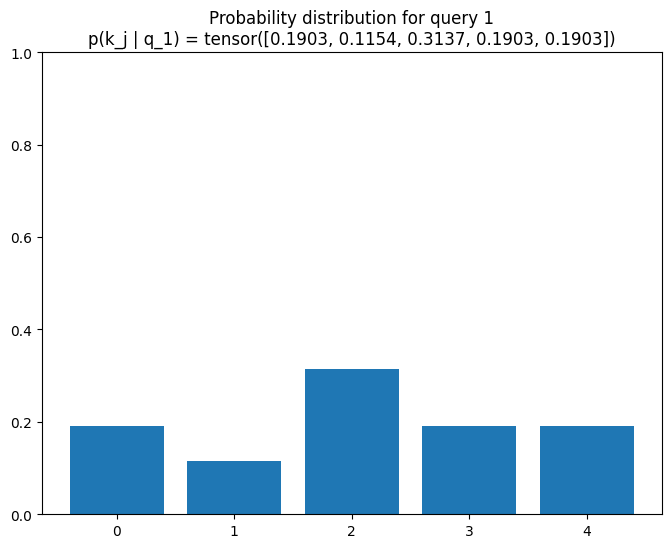

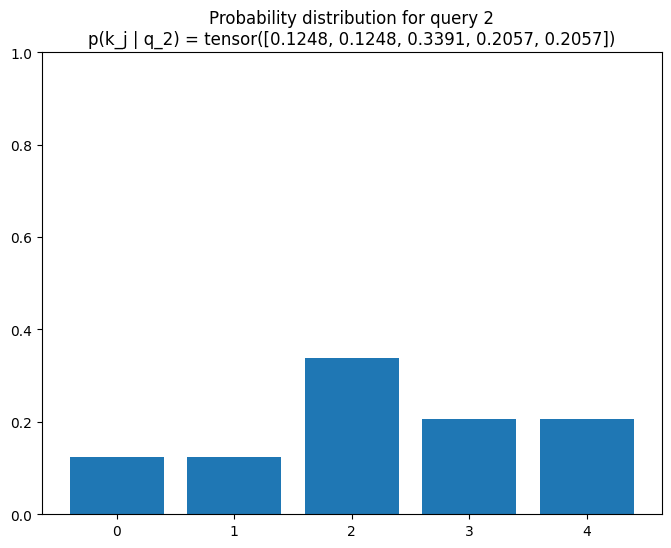

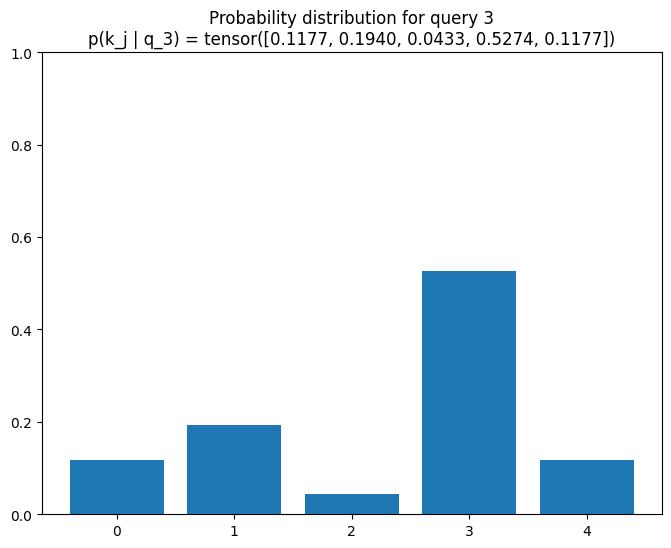

In [3]:

def prob_distribution(Q, K):
    dk = K.shape[-1]
    dot_prod = (tt.matmul(Q,K.T)/(dk**0.5))
    weights = tt.softmax(dot_prod, dim=-1)
    return weights, dot_prod


weights, dot_prod = prob_distribution(Q,K)
print(f"""

Dot Prod: {dot_prod.shape} : 
{dot_prod}

Softmax Weights: {weights.shape}
{weights}


""")

# for each query plot the measure - each row is one query
for qi in range(L_q): 
    plt.figure(figsize=(8,6))
    plt.title(f'Probability distribution for query {qi+1}\n'+f'p(k_j | q_{qi+1}) = {weights[qi]}')
    plt.ylim(0, 1)
    _ = plt.bar(range(L_k), weights[qi])
    plt.show()



## [b] finding Query sparsity measure

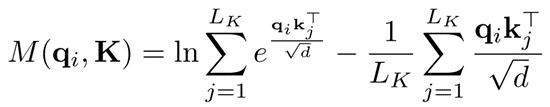

$M$ defines the sparsity measure for a query $q_i$ on a set of keys $K$. Here $L_k$ is the total number of keys and $d$ is the dimensions of keys.

The larger the value of $M(q_i, K)$, the more dominant the query $q_i$ is 

In [4]:
def Query_Sparsity_Measure(qi, K):
    
    Lk = len(K) # no of keys
    root_d = K.shape[-1]**0.5 # square root of d

    first_part, second_part = 0.0, 0.0
    for j in range(Lk): 
        scaled_dot_prod = (tt.dot(qi, K[j])/root_d) # q_i*k_j / root_d
        first_part  += tt.e**scaled_dot_prod
        second_part += scaled_dot_prod

    first_part = tt.log(first_part) #<--- log base e
    second_part = second_part/Lk
    
    return  first_part - second_part

# find the measure for each query
QSM = []
for i,q in enumerate(Q):
    M_qi = Query_Sparsity_Measure(q, K).item()
    QSM.append(M_qi)
    print(f'M(q_{i+1}, K) = {M_qi:.4f}')

QSM = tt.tensor(QSM)
print(f'{QSM=}')

# sort in descending order to arrange as per dominance
soreted_query = tt.argsort(QSM, descending=True)
#print(f'{soreted_query=}')
print('\n\n')
most_dominat = soreted_query[0]
least_dominat = soreted_query[-1]
print(f'Query q_{most_dominat+1} is the most dominant with highest QSM = {QSM[most_dominat]:.4f}')
print(f'Query q_{least_dominat+1} is the least dominant with lowest QSM = {QSM[least_dominat]:.4f}')

M(q_1, K) = 1.6592
M(q_2, K) = 1.6814
M(q_3, K) = 1.9399
QSM=tensor([1.6592, 1.6814, 1.9399])



Query q_3 is the most dominant with highest QSM = 1.9399
Query q_1 is the least dominant with lowest QSM = 1.6592
